# Solving the n-Queens Problem using Local Search

Student Name: Jonathan Mejia

I have used the following AI tools: ChatGPT and Gemini

I understand that my submission needs to be my own work: JM

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.


## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum.

## Helper functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from numba import njit

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""

    return(np.random.randint(0,n, size = n))

@njit()
def comb2_jit(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

@njit()
def conflicts_jit(board):
    """Calculate the number of conflicts, i.e., the objective function."""

    n = len(board)

    cnt = [0] * (5 * n)

    for i in range(n):
        cnt[board[i]] += 1
        cnt[(n) + (i + board[i])] += 1
        cnt[(3 * n) + (i - board[i] + n)] += 1

    conflicts = 0
    for x in cnt:
        conflicts += comb2_jit(x)

    return conflicts

# decrease the font size to fit larger boards
def show_board(board, cols = ['white', 'gray'], fontsize = 48):
    """display the board"""

    n = len(board)

    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0):
                display[i,j] = 1

    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap,
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])

    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize,
                 horizontalalignment = 'center',
                 verticalalignment = 'center')

    print(f"Board with {conflicts_jit(board)} conflicts.")
    plt.show()

## Create a board

Board with 4 conflicts.


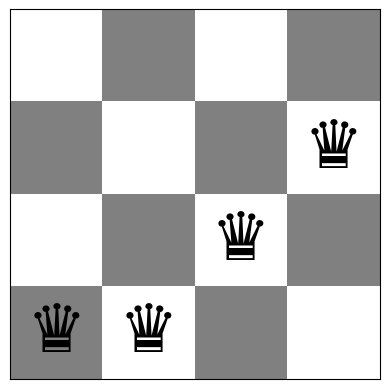

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [3]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts_jit(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


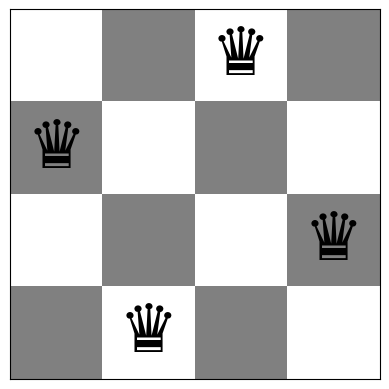

In [4]:
board = [1,3,0,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [30 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum.

Board with 2 conflicts.


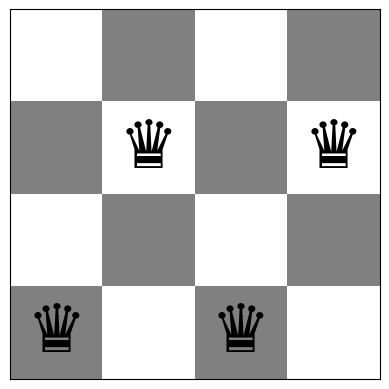

Number of conflicts before climbing: 2
Number of conflicts after climbing: 0


In [6]:
# Finds the best successor and to update the new implemented board
def best_successor(board):
  length = len(board)
  best_result = board
  for row in range(length):
    for column in range(length):
      if column != board[row]:
        new_board = list(board)
        new_board[row] = column
        if conflicts_jit(new_board) < conflicts_jit(best_result):
          best_result = new_board
  return best_result

# Steepest-ascend Hill climbing Search
def hill_climbing(board):
  current = board
  while conflicts_jit(current):
    neighbor = best_successor(current)
    if conflicts_jit(neighbor) >= conflicts_jit(current):
      return current
    current = neighbor
  return current


board = random_board(4)
show_board(board)
print(f"Number of conflicts before climbing: {conflicts_jit(board)}")
board = hill_climbing(board)
print(f"Number of conflicts after climbing: {conflicts_jit(board)}")


## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

Board with 4 conflicts.


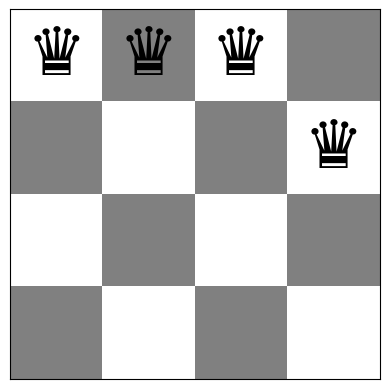

Number of conflicts before climbing: 4
Number of conflicts after climbing: 1


In [5]:
import random

# Chooses randomly looking for potential moves, limit the amount of random moves searched for by
# 5 to keep a smaller search
def uphill_improv_moves(board):
  random_neighbors = []
  for i in range(5):
    new_board = list(board)
    new_board[random.randint(0,(len(board)-1))] = random.randint(0,(len(board)-1))
    random_neighbors.append(new_board)
  return random_neighbors

# Implements the stochastic hill climbing algorithm by checking the above methods passed
# random neighbors if the moves are sufficient to update the board best. Keeping this algorithm
# to 1000 moves to avoid infinite loops
def stochastic_hill_climbing(board):
  current = list(board)
  for i in range(1000):
    if conflicts_jit(current) == 0:
      return current
    new_board = list(current)
    neighbors = uphill_improv_moves(new_board)
    new_board = neighbors[random.randrange(len(neighbors))]
    if conflicts_jit(new_board) < conflicts_jit(current):
      current = new_board
  return current


board = random_board(4)
show_board(board)
print(f"Number of conflicts before climbing: {conflicts_jit(board)}")
board = stochastic_hill_climbing(board)
print(f"Number of conflicts after climbing: {conflicts_jit(board)}")

## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

Board with 5 conflicts.


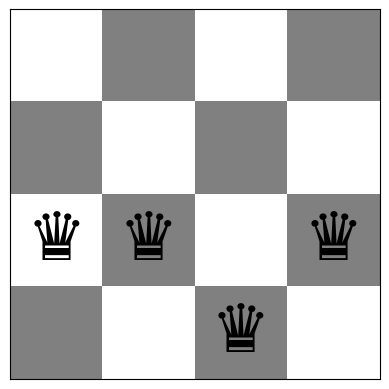

Number of conflicts before climbing: 5
Number of conflicts after climbing: 1


In [7]:
# Implements similar randomness but this time updating the first random board
# that improves the moves to the best solution. Again limiting the cost to minimize
# finding a local optimum that will cause an infinite loop.
import random

def first_choice_hill_climbing(board):
  current = list(board)
  for i in range(1000):
    if conflicts_jit(current) == 0:
      return current
    new_board = list(current)
    new_board[random.randint(0,(len(current)-1))] = random.randint(0,(len(current)-1))
    if conflicts_jit(new_board) < conflicts_jit(current):
      current = new_board
  return current


board = random_board(4)
show_board(board)
print(f"Number of conflicts before climbing: {conflicts_jit(board)}")
board = first_choice_hill_climbing(board)
print(f"Number of conflicts after climbing: {conflicts_jit(board)}")

## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algorithm several times starting with a new random board.

In [8]:
# The following will now  implement restarts and if the respective methods called
# for each algorithm do not find an optimal solution the restart will take place to
# get a new board to hopefully find a optimal solution before restarting 100 times.
board = random_board(4)

board1 = list(board)
board2 = list(board)
board3 = list(board)

counter1 = 0
counter2 = 0
counter3 = 0

while conflicts_jit(board1) > 0 and counter1 < 100:
  board1 = random_board(8)
  board1 = hill_climbing(board1)
  counter1 += 1
print(f"Number of conflicts after Steepest-ascend Hill Climbing restarts: {conflicts_jit(board1)}")
print("Number of restarts: " , counter1,"\n")

while conflicts_jit(board2) > 0 and counter2 < 100:
  board2 = random_board(8)
  board2 = stochastic_hill_climbing(board2)
  counter2 += 1
print(f"Number of conflicts after Stochastic Hill Climbing restarts: {conflicts_jit(board2)}")
print("Number of restarts: " , counter2,"\n")

while conflicts_jit(board3) > 0 and counter3 < 100:
  board3 = random_board(8)
  board3 = first_choice_hill_climbing(board3)
  counter3 += 1
print(f"Number of conflicts after First-choice Hill climbing restarts: {conflicts_jit(board3)}")
print("Number of restarts: " , counter3,"\n")

Number of conflicts after Steepest-ascend Hill Climbing restarts: 0
Number of restarts:  24 

Number of conflicts after Stochastic Hill Climbing restarts: 0
Number of restarts:  3 

Number of conflicts after First-choice Hill climbing restarts: 0
Number of restarts:  19 



## Task 5: Simulated Annealing [10 Points]

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


1. Implement simulated annealing for the n-Queens problem.
2. Compare the performance with the previous algorithms.
2. Discuss your choice of annealing schedule.

Board with 1 conflicts.


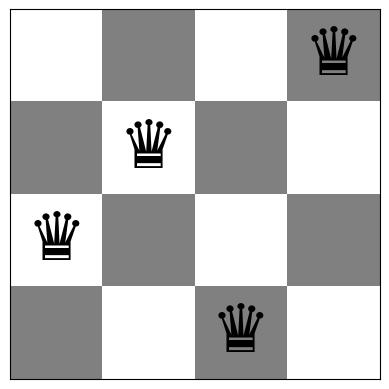

Number of conflicts before climbing: 1
Number of conflicts after climbing: 0


In [8]:
# The following algorithm will implement the simulated annealing algorithm
import math

def schedule(t):
  alpha = .82
  return T * (alpha ** t)

def simulated_annealing(board, schedule):
  current = list(board)
  for t in range(1,1000):
    T = schedule(t)
    if T == 0:
      return current
    next = list(current)
    next[random.randint(0,(len(current)-1))] = random.randint(0,(len(current)-1))
    delta_e = conflicts_jit(next) - conflicts_jit(current)
    if delta_e < 0:
      current = next
    else:
      p = math.exp(-delta_e/T)
      if random.random() < p:
        current = next
  return current


T = 10000
board = random_board(4)
show_board(board)
print(f"Number of conflicts before climbing: {conflicts_jit(board)}")
board = simulated_annealing(board,schedule)
print(f"Number of conflicts after climbing: {conflicts_jit(board)}")

## Task 6: Compare Performance [10 Points]

Compare the algorithm using runtime and objective function values. Use boards of size 4 and 8 to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 100 times) with different starting boards and report averages.


Add the used code and the answer to the following questions below.

* How do the algorithms scale with problem size? You will need to run more board sizes. You can add the results to the table above and show the result as a chart.

* What is the largest board each algorithm can solve in a reasonable amount time?

Hint: See [Profiling Python Code](../HOWTOs/profiling_code.ipynb) for help about how to measure runtime in Python.

                     Algorithm  NxN Queens  Average Time  Average Conflicts  \
0                hill_climbing           4      0.000534               0.75   
1     stochastic_hill_climbing           4      0.002240               0.72   
2   first_choice_hill_climbing           4      0.001722               0.66   
3          simulated_annealing           4      0.017544               0.00   
4                hill_climbing           8      0.006947               1.23   
5     stochastic_hill_climbing           8      0.004982               1.70   
6   first_choice_hill_climbing           8      0.004265               1.50   
7          simulated_annealing           8      0.026358               0.20   
8                hill_climbing          12      0.043467               1.55   
9     stochastic_hill_climbing          12      0.006488               2.95   
10  first_choice_hill_climbing          12      0.005938               2.93   
11         simulated_annealing          12      0.03

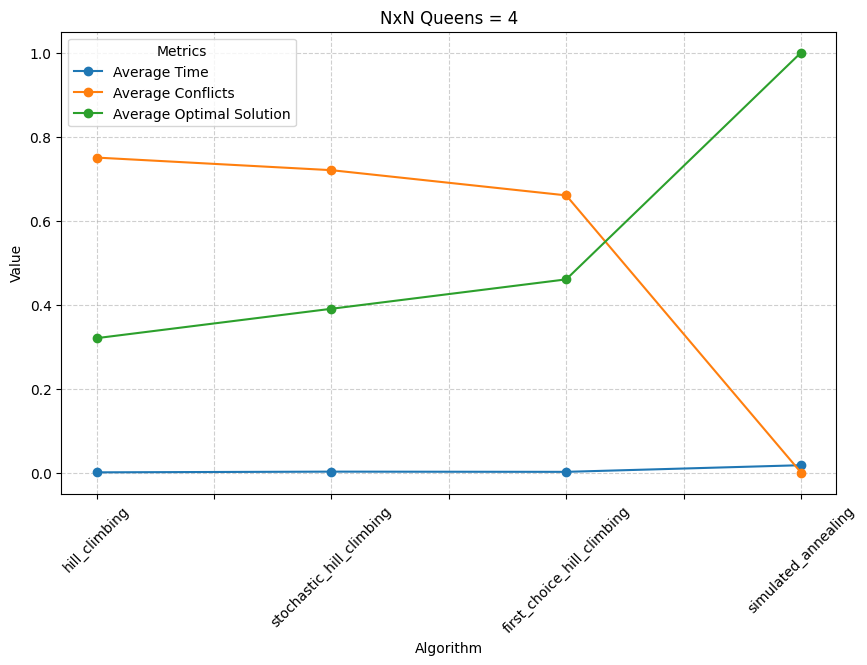

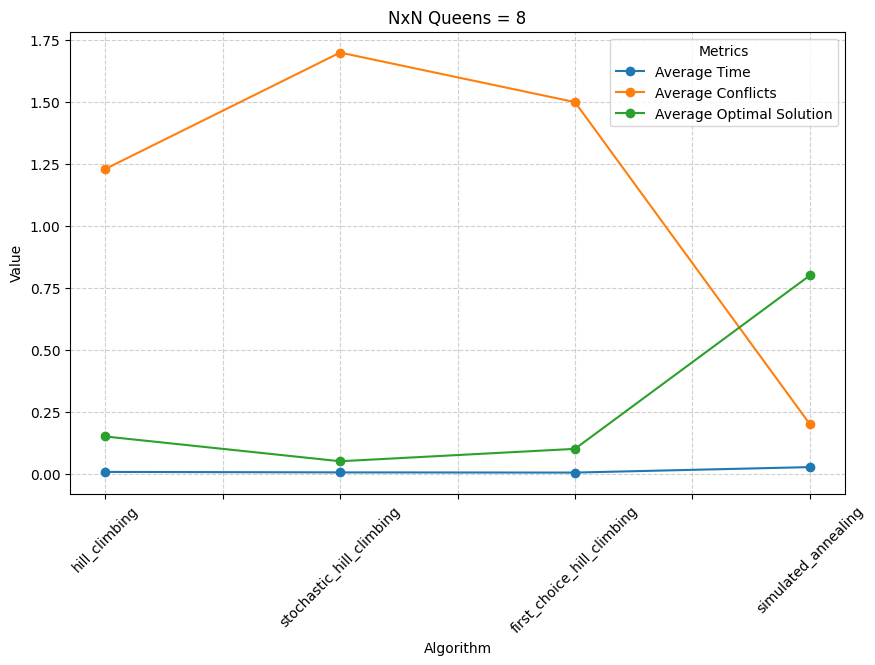

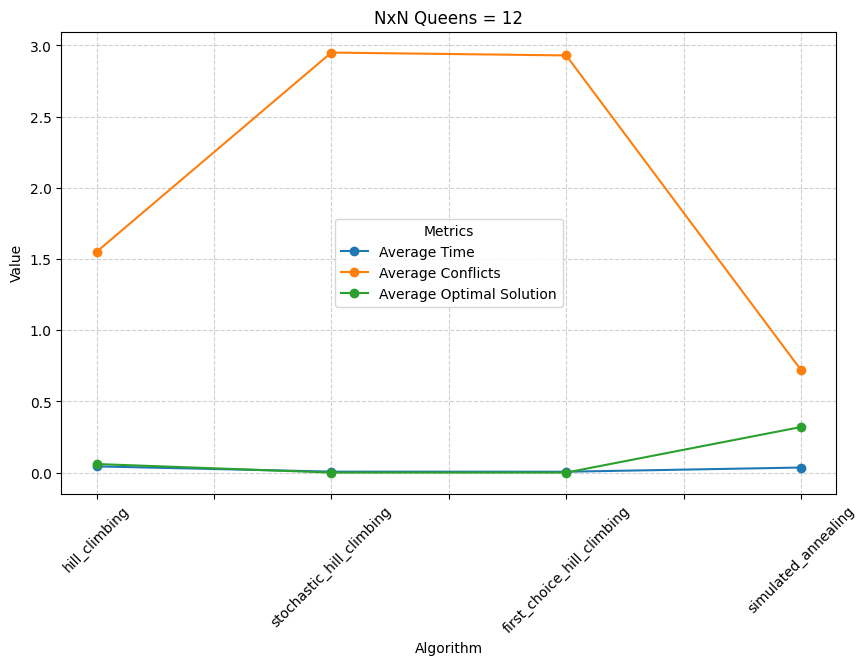

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Code, results, charts and discussion go here
import time
board_sizes = [4,8,12]
algorithms = ["hill_climbing","stochastic_hill_climbing","first_choice_hill_climbing","simulated_annealing"]
results = []
opt_count=0
opt_counts = []
avg_time=0
avg_times = []
avg_conflict=0
avg_conflicts = []
for board_s in board_sizes:
  for alg in algorithms:
    avg_time = 0
    avg_conflict = 0
    opt_count = 0
    for iter in range(100):
      if alg == "hill_climbing":
        board = random_board(board_s)
        start = time.time()
        board = hill_climbing(board)
        end = time.time()
        avg_time += (end - start)
        avg_conflict += conflicts_jit(board)
        if conflicts_jit(board) == 0:
          opt_count += 1
      if alg == "stochastic_hill_climbing":
        board = random_board(board_s)
        start = time.time()
        board = stochastic_hill_climbing(board)
        end = time.time()
        avg_time += (end - start)
        avg_conflict += conflicts_jit(board)
        if conflicts_jit(board) == 0:
          opt_count += 1
      if alg == "first_choice_hill_climbing":
        board = random_board(board_s)
        start = time.time()
        board = first_choice_hill_climbing(board)
        end = time.time()
        avg_time += (end - start)
        avg_conflict += conflicts_jit(board)
        if conflicts_jit(board) == 0:
          opt_count += 1
      if alg == "simulated_annealing":
        board = random_board(board_s)
        T = 10000
        start = time.time()
        board = simulated_annealing(board,schedule)
        end = time.time()
        avg_time += (end - start)
        avg_conflict += conflicts_jit(board)
        if conflicts_jit(board) == 0:
          opt_count += 1
    results.append([alg,board_s,avg_time/100,avg_conflict/100,opt_count/100])


# Create a DataFrame with updated column names
df = pd.DataFrame(results, columns=['Algorithm', 'NxN Queens', 'Average Time', 'Average Conflicts', 'Average Optimal Solution'])
print(df)
# Plot each NxN Queens group separately
# Plot each NxN Queens group separately as line charts
for n in board_sizes:
    df_n = df[df['NxN Queens'] == n]  # Filter for each NxN Queens size

    # Set index for clear labels
    df_n.set_index('Algorithm', inplace=True)

    # Select only numerical columns for plotting
    df_n[['Average Time', 'Average Conflicts', 'Average Optimal Solution']].plot(
        kind='line', marker='o', figsize=(10, 6), title=f'NxN Queens = {n}'
    )

    # Customize the plot
    plt.ylabel('Value')
    plt.xlabel('Algorithm')
    plt.legend(title="Metrics")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()

## Advanced task: Exploring other Local Moves

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

Implement a few different local moves. Implement:

* moving one queen only one square at a time
* switching two columns
* move two queens at a time

Compare the performance of these moves for the 8-Queens problem using your stochastic hill climbing 2 implementation from above. Also consider mixing the use of several types of local moves (e.g., move one queen and moving two queens).

Describe what you find out about how well these moves and combinations of these moves work.

Board with 3 conflicts.


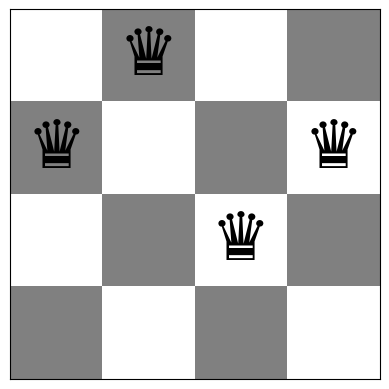

Number of conflicts before climbing: 3
Number of conflicts after climbing: 0


In [21]:
def move_one_queen(board):
  col = random.randint(0,len(board)-1)
  row = board[col]
  new_board = list(board)
  new_board[col] = row
  p_moves = [row+1,row-1]
  moves = [x for x in p_moves if x >= 0 and x < len(board)]
  if len(moves) > 0:
    new_board[col] = moves[random.randint(0,len(moves)-1)]
  return new_board

def hill_climbing_one_queen(board):
  current = board
  counter = 0
  while conflicts_jit(current) and counter < 10000:
    new_board = move_one_queen(current)
    current = new_board
    counter += 1
  return current

board = random_board(4)
show_board(board)
print(f"Number of conflicts before climbing: {conflicts_jit(board)}")
board = hill_climbing_one_queen(board)
print(f"Number of conflicts after climbing: {conflicts_jit(board)}")

Board with 2 conflicts.


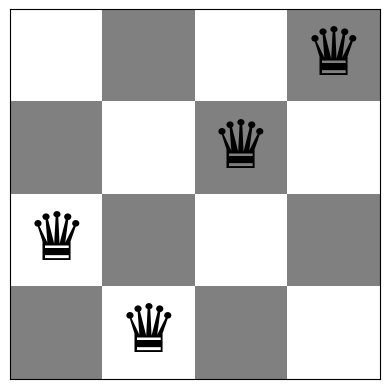

Number of conflicts before climbing: 2
Number of conflicts after climbing: 0


In [16]:
def switching_cols(board):
  current = board
  for i in range(1000):
    new_board = list(current)
    col1 = random.randint(0,len(current)-1)
    col2 = random.randint(0,len(current)-1)
    new_board[col1] = current[col2]
    new_board[col2] = current[col1]
    if conflicts_jit(new_board) == 0:
      current = new_board
      break
    if conflicts_jit(new_board) < conflicts_jit(current):
      current = new_board
  return current

board = random_board(4)
show_board(board)
print(f"Number of conflicts before climbing: {conflicts_jit(board)}")
board = switching_cols(board)
print(f"Number of conflicts after climbing: {conflicts_jit(board)}")

Board with 5 conflicts.


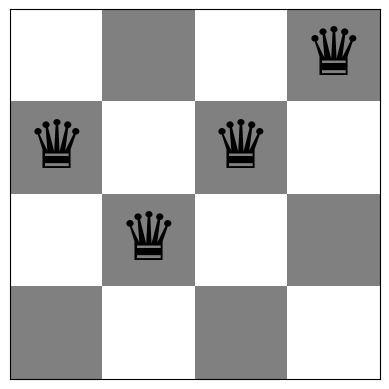

Number of conflicts before climbing: 5
Number of conflicts after climbing: 1


In [12]:
import random
def improv_moves(board):
  length = len(board)
  best_result = board
  neighbors = []
  for row in range(length):
    for column in range(length):
      if column != board[row]:
        new_board = list(board)
        new_board[row] = column
        if conflicts_jit(new_board) < conflicts_jit(best_result):
          neighbors.append((row,column))
  return neighbors


def update_two_queens(board):
  current = list(board)
  for i in range(100):
    if conflicts_jit(current) == 0:
      return current
    new_board = list(current)
    neighbors = improv_moves(new_board)
    if len(neighbors) > 1:
      new_board[neighbors[0][0]] = neighbors[0][1]
      new_board[neighbors[1][0]] = neighbors[1][1]
    elif len(neighbors) == 1:
      new_board[neighbors[0][0]] = neighbors[0][1]
    else:
      return current
    if conflicts_jit(new_board) < conflicts_jit(current):
      current = new_board
  return current


board = random_board(4)
show_board(board)
print(f"Number of conflicts before climbing: {conflicts_jit(board)}")
board = update_two_queens(board)
print(f"Number of conflicts after climbing: {conflicts_jit(board)}")

In [23]:
import time
import pandas as pd

board_sizes = [4,8]
algorithms = ["first_choice_hill_climbing","hill_climbing_one_queen","switching_cols","update_two_queens"]
results = []
opt_count=0
opt_counts = []
avg_time=0
avg_times = []
avg_conflict=0
avg_conflicts = []
for board_s in board_sizes:
  for alg in algorithms:
    avg_time = 0
    avg_conflict = 0
    opt_count = 0
    for iter in range(100):
      if alg == "first_choice_hill_climbing":
        board = random_board(board_s)
        start = time.time()
        board = first_choice_hill_climbing(board)
        end = time.time()
        avg_time += (end - start)
        avg_conflict += conflicts_jit(board)
        if conflicts_jit(board) == 0:
          opt_count += 1
      if alg == "hill_climbing_one_queen":
        board = random_board(board_s)
        start = time.time()
        board = hill_climbing_one_queen(board)
        end = time.time()
        avg_time += (end - start)
        avg_conflict += conflicts_jit(board)
        if conflicts_jit(board) == 0:
          opt_count += 1
      if alg == "switching_cols":
        board = random_board(board_s)
        start = time.time()
        board = switching_cols(board)
        end = time.time()
        avg_time += (end - start)
        avg_conflict += conflicts_jit(board)
        if conflicts_jit(board) == 0:
          opt_count += 1
      if alg == "update_two_queens":
        board = random_board(board_s)
        start = time.time()
        board = update_two_queens(board)
        end = time.time()
        avg_time += (end - start)
        avg_conflict += conflicts_jit(board)
        if conflicts_jit(board) == 0:
          opt_count += 1
    results.append([alg,board_s,avg_time/100,avg_conflict/100,opt_count/100])


# Create a DataFrame with updated column names
df = pd.DataFrame(results, columns=['Algorithm', 'NxN Queens', 'Average Time', 'Average Conflicts', 'Average Optimal Solution'])
print(df)

                    Algorithm  NxN Queens  Average Time  Average Conflicts  \
0  first_choice_hill_climbing           4      0.001947               0.74   
1     hill_climbing_one_queen           4      0.002287               0.00   
2              switching_cols           4      0.034366               2.10   
3           update_two_queens           4      0.003051               1.09   
4  first_choice_hill_climbing           8      0.003994               1.57   
5     hill_climbing_one_queen           8      0.174295               7.74   
6              switching_cols           8      0.046104               4.29   
7           update_two_queens           8      0.047521               1.84   

   Average Optimal Solution  
0                      0.37  
1                      1.00  
2                      0.09  
3                      0.38  
4                      0.06  
5                      0.06  
6                      0.00  
7                      0.16  
